# Linear Regression - Sales Analysis

## Introduction

In this project, we are going to learn how to use linear regression to predict numeric variables. Linear regression is used to show the relationship between 2 variables. You might be familiar with this from studying algebra, where you have a chart showing independent values (predictor) variables on the horizontal x axis and dependent (predicted) variables on the vertical y axis. The function of that chart is y = mx + b, where y is the variable to be predicted, x is the independent variable, m is the slope of the line between 2 points and b is the point on the y axis where the line intersects when x = 0. Linear regression attempts to create this function between 2 numeric variables and fit the line is such a way that reduces the errors in predictions. Here we are going to use linear regression to predict the total amount of a sales transaction based upon 2 demographic variables for our customers, age and income.

### Preparation

To begin, let's first import the packages we will need for this example and then define 2 functions we will need to show the distribution of our data and calculate the regression for our model.

In [21]:
# Import Packages
import pandas as pd
import pandasql as ps
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
import openpyxl

In [31]:
def show_distribution(var_data, x_label,plot_title):

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'blue', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel(x_label)

    # Add a title to the Figure
    fig.suptitle(plot_title)

    # Show the figure
    plt.show()

def show_regression(df, x_var, y_var):
    df_regression = df[[x_var,y_var]].copy()

    # Get the regression slope and intercept
    m, b, r, p, se = stats.linregress(df_regression[x_var], df_regression[y_var])
    print('slope: {:.4f}\ny-intercept: {:.4f}'.format(m, b))    
    print('f(x) = {:.4f}x + {:.4f}'.format(m, b))

    # Use the function (mx + b) to calculate f(x) for each x (StudyHours) value
    df_regression['fx'] = (m * df_regression[x_var]) + b

    # Calculate the error between f(x) and the actual y (Grade) value
    df_regression['error'] = df_regression['fx'] - df_regression[y_var]

    # Create a scatter plot of Grade vs StudyHours
    df_regression.plot.scatter(x=x_var, y=y_var)

    # Plot the regression line
    plt.plot(df_regression[x_var], df_regression['fx'], color='cyan')

    # Display the plot
    plt.show()

I have set the display options to show all columns and rows for readability. You may skip this step if it's not needed.

In [ ]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 240)
pd.set_option('display.max_rows', None)

Now let's import our data. We have data in 2 excel files which we will import to data frames. The first data set is our sales data. This file contains details for 5000 transactions. The second data set is our customer table, which contains 2 demographic factors, age and income.

In [23]:
sales_df = pd.read_excel(r"C:\Users\brian\OneDrive\Desktop\Jupyter Projects\Project 1-Linear Regression\Sales_data.xlsx")
customer_df = pd.read_excel(r"C:\Users\brian\OneDrive\Desktop\Jupyter Projects\Project 1-Linear Regression\Customer_data.xlsx")

print(sales_df.tail())
print(customer_df.tail())

      Transaction_ID Transaction_Date  Customer_ID       Price  Quantity      Amount
4995            4996       2025-04-12           20   35.583333         8  284.666667
4996            4997       2025-04-12          402   66.222222         9  596.000000
4997            4998       2025-04-12           81  696.666667         1  696.666667
4998            4999       2025-04-12          373   46.866667        10  468.666667
4999            5000       2025-04-12          368  199.500000         1  199.500000
     Customer_ID  Age         Income
495          496   33  397667.500000
496          497   67  398920.833333
497          498   30  400344.166667
498          499   56  402169.166667
499          500   69  410441.000000


Now that we have imported our data, we need to join the 2 datasets since we will be examining the relationship between transaction amount age as well as income.

But why would we use these variables in the first place? In this example, we are attempting to determine if there are some factors which predict higher transaction amounts. In the real world, you might have to do just that and may consider many predicitive features depending on the industry and context. In this case, we are assuming that people of different age groups and income brackets behave differently when it comes to making large purchases. If this happens to be true, it may reveal the opportunity to improve sales by targeting customers who are likely to spend more than others. Linear regression is going to help us understand the relationships between these variables and confirm what kind of predictive power they hold.

Now let's join our datasets. There are many ways to join dataframes in python, however I like to use SQL queries since they are simple to use. Here, we are joining the 2 tables by customer ID in order to associate the customer age and income with each transaction.

In [24]:
# EXPLORATION -
# Join Data
join_query = "SELECT s.*, c.Age, c.Income FROM sales_df s LEFT JOIN customer_df c on s.Customer_ID = c.Customer_ID"
full_data = ps.sqldf(join_query, locals())

print(full_data.tail())

      Transaction_ID            Transaction_Date  Customer_ID       Price  Quantity      Amount  Age         Income
4995            4996  2025-04-12 00:00:00.000000           20   35.583333         8  284.666667   21   79030.111111
4996            4997  2025-04-12 00:00:00.000000          402   66.222222         9  596.000000   72  271198.666667
4997            4998  2025-04-12 00:00:00.000000           81  696.666667         1  696.666667   66  120430.000000
4998            4999  2025-04-12 00:00:00.000000          373   46.866667        10  468.666667   37  257528.222222
4999            5000  2025-04-12 00:00:00.000000          368  199.500000         1  199.500000   21  255631.777778


Now you can see that we have created a new data frame which holds our original sales data, but with 2 added variables, age and income.

Before we begin creating a regression model, it is helpful to understand the distributions of our variables. We are going to use the show_distribution function we created earlier to print summary statistics, histograms and boxplots of each variable.

### Preliminary Analysis

Minimum:54.00
Mean:401.94
Median:358.89
Mode:175.00
Maximum:1033.33



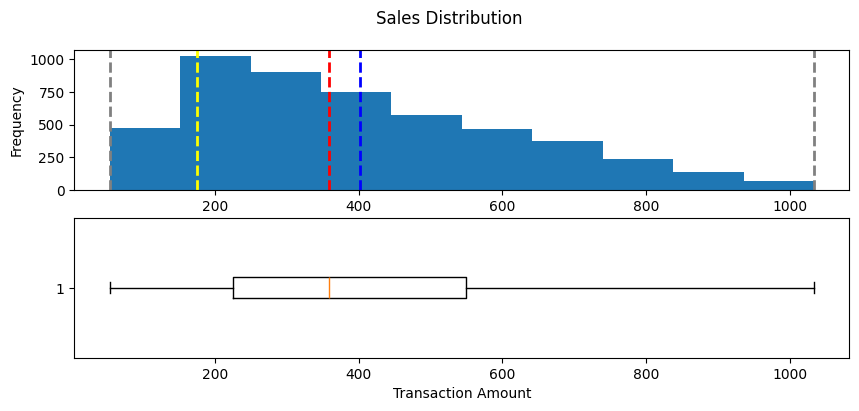

In [27]:
# Visual - Distribution of Sales
txnAmt_data = full_data['Amount']
show_distribution(txnAmt_data,'Transaction Amount','Sales Distribution')

As you can see, the function first prints the minimum, mean, median, mode and maximum. The histogram is overlayed above the boxplot to visualize the distribution of transaction amounts. Within the box plot, you can see that there are 2 gray lines showing the minimum and maximum, the red line represents the median, while the blue and yellow lines show the mean and mode, respectively. Here we can see that the data is right skewed with most sales totaling less than $500. Fewer transaction reach the $600-$1000 mark. We want to know if there are any factors we can use to predict which customers are likely to spend those higher amounts. But before we do that, let's look at the same distributions for our independent variables.

Minimum:18.00
Mean:48.03
Median:50.00
Mode:37.00
Maximum:75.00



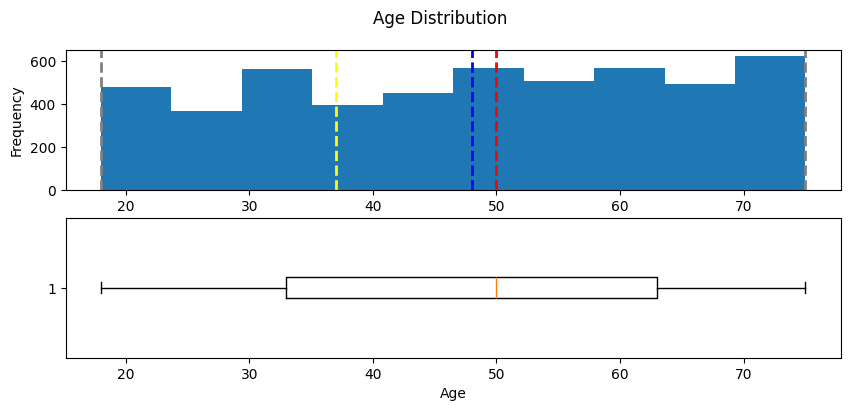

Minimum:53158.83
Mean:201889.43
Median:193329.78
Mode:152026.39
Maximum:410441.00



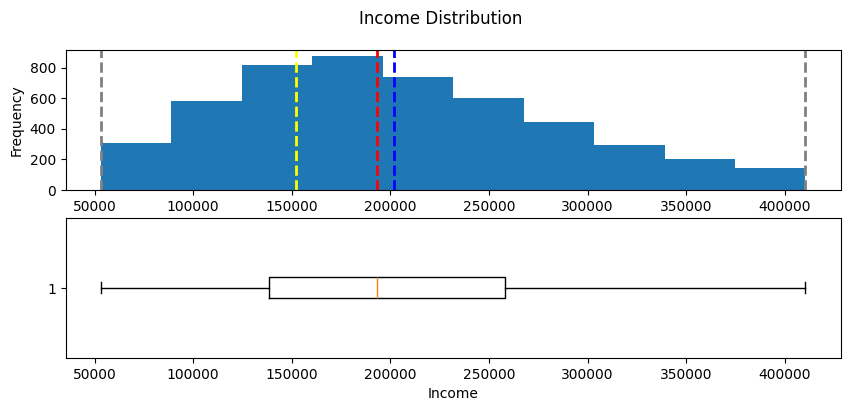

In [30]:
# Visual - Distribution of Age
age_data = full_data['Age']
show_distribution(age_data,'Age','Age Distribution')
# Visual - Distribution of Income
income_data = full_data['Income']
show_distribution(income_data,'Income','Income Distribution')

From the visuals above, you can see that our customer base is distributed fairly evenly by age, from 18 to 75, with most customers between the ages of 35-65. Income is more normally distributed along a bell curve, with a slight skew to the right. 

Now let's use the show_regression function to visualize the relationship between transaction amount and each of our predictor variables, starting with age.

slope: 8.2830
y-intercept: 4.1240
f(x) = 8.2830x + 4.1240


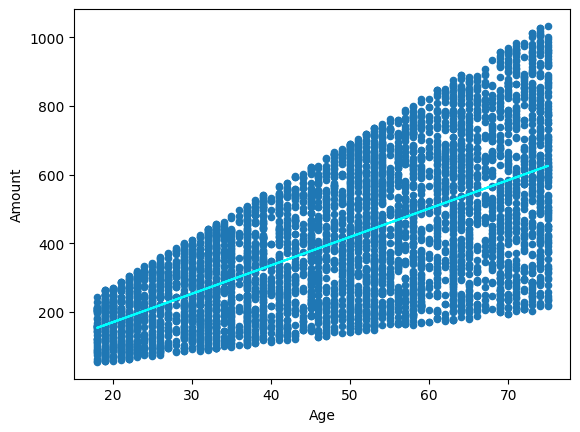

In [32]:
# Visual - Scatter Plot of Sales/Age
show_regression(full_data,'Age','Amount')

Looking at the scatterplot, you can see that there is a clear, positive relationship between age and transaction amount. To put it simply, the older our customer is, the higher their average amount spent per transaction. You can also see a light blue line above the plot points. This line is the regression line. The function "f(x) = 8.2831x + 4.1240" above the plot is the function, or line, that best fits the data to minimize predictive error. Essentially what this function tells us is that for each increase of 1 year of age for any of our customers, average transaction amount should increase by $8.28.

There are 2 big caveats here. The first is that since this is sample data, the relationship between these 2 variables is obvious. In real life, mot relationships will not appear this 'clean' and it will take more than visual analysis to confirm the strength of any relationship. The second caveat is that we a re ultimately showing a correlation, but this does not prove a causal relationship. There may be many reason why older customers tend to spend more per transaction that have nothing to do with age. Right now we are not attempting to perform a causal analysis, but rather we are trying to assess statistically whether we can confirm a significant predictive relationship, which then can guide further exploration into other factors which are the true drivers of customer spend.

Now let's see the same chart showing the relationship between transaction amount and income.

slope: -0.0000
y-intercept: 402.3370
f(x) = -0.0000x + 402.3370


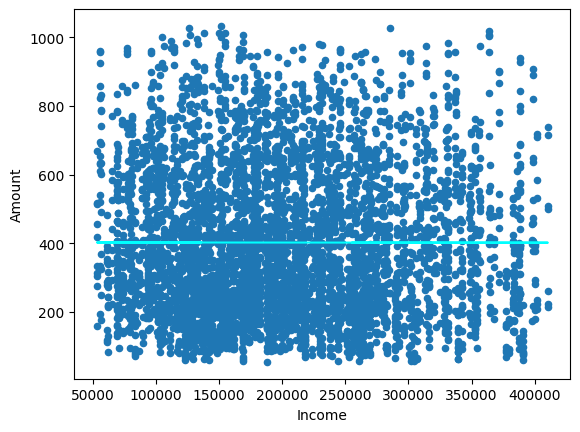

In [33]:
# Visual - Scatter Plot of Sales/Income
show_regression(full_data,'Income','Amount')

Here there is no discernible relationship. Whether a customer earns as low as $50,000 per year or over $400,000, it does not seem to have much impact on the amount spent per transaction. You can also see that the regression line is somewhat flat, indicating a very low correlation.

Now that we have seen these relationships visually, let calculate them statistically and start assessing their predictive power. We'll start by printing a correlation matrix.

In [34]:
# ANALYSIS
# Correlations
# Correlation Matrix Amount/Age/Income
correlation_matrix = full_data[['Amount','Age','Income']].corr()
print(correlation_matrix)

          Amount       Age    Income
Amount  1.000000  0.640107 -0.000728
Age     0.640107  1.000000 -0.010397
Income -0.000728 -0.010397  1.000000


In statistics, a correlation is measured by a value between -1 and 1, where values above 0 indicate a postive relationship and those below show a negative relationship. The further a correlation is from 0, whether positive or negative, the greater the strength of the relationship. In the matrix above, you can see that each variable has a correlation of 1.0 to itself, which is makes sense since any variable show be perfectly corrleated to itself. From our scatterplot, we are expecting to see a strong positive correlation between age and transaction amount, which we do (0.64). Income on the other hand showed and nearly flat regression line so we should epect this value to be close to 0. Here we can see that the correlation statistic between income and transaction amount os -0.000728, an amount that is extremely small confirming that income has little to no impact on sales amount.

But this is not the end of our analysis. We cannot assume based on these correlations alone that these relationships are statistically meaningful. We may have a very strong correlation, but not enough data to confirm statistically that there is such a relationship. It is possible that these relationships could be created by random variation, in which case, our correlations are misleading. To assess the likelihood of our data being produced by random chance, we need to calculate a p-value. P-values are measured on a scale of 0 to 1, with higher p-values indicating a greater likelihood that a correlation could be produced by simply randomizing the data. Typically, when p-values are below 0.05, we determine that the relationship is unlikely to be caused by random chance and conclude that the observed relationship is statistically meaningful.

In [35]:
# Correlation Age/Sales
correlation, p_value = pearsonr(full_data['Age'], full_data['Amount'])
print(f"Age/Amount Pearson correlation: {correlation}")
print(f"Age/Amount P-value: {p_value}")
# Correlation Income/Sales
correlation, p_value = pearsonr(full_data['Income'], full_data['Amount'])
print(f"Income/Amount Pearson correlation: {correlation}")
print(f"Income/Amount P-value: {p_value}")

Age/Amount Pearson correlation: 0.640107451901916
Age/Amount P-value: 0.0
Income/Amount Pearson correlation: -0.0007282629111018402
Income/Amount P-value: 0.9589405717064825


Here we have printed the same pearson correlations that we observed before, but this time with their associated p-values. You can see that the p-value for the relationship between age and transaction amount is 0 (or so low that the function has not represented it here). Given that we have a p-value below 0.05, we can reject the null hypothesis (that is, we can say that the observed correlation of 0.64 between these variables is unlikely to be created by random variation and is therefore statistically meaningful). 

Conversely, when it comes to the relationship between income and transaction amount, our p-value is greater than 0.95. This means that the relationship is very likely to be reproducable by simply randomizing these variables. This is not surprising and in fact affirms exactly what we have observed thus far.

### Regression Model Age:Transaction Amount

Now that we have seen that there is a statistically meaningful correlation between age and transaction amount, let's try to determine exactly how much predictive power age has. We'll now create our regression model to produce the metrics we need.

In [42]:
# Separate features and labels
X, y = full_data['Age'].values, full_data['Amount'].values
X = X.reshape(-1,1)

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))
# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels (Sample): ', np.round(predictions)[:10])
print('Actual labels (Sample): ' ,y_test[:10])

Training Set: 3500 rows
Test Set: 1500 rows
Predicted labels (Sample):  [220. 228. 534. 187. 427. 617. 419. 543. 270. 617.]
Actual labels (Sample):  [171.88888889 306.         839.11111111 224.88888889 178.5
 990.77777778 438.88888889 682.5        369.77777778 731.77777778]


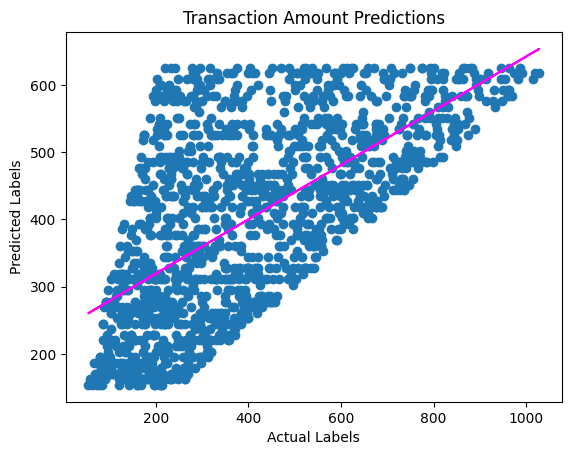

In [43]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Transaction Amount Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

We just created a linear regression model to predict transaction amounts using age as our predictive variable. Then we mapped the actual values against the predicted values on the scatterplot above. You can see that there is a great deal of variance, but how much? And, how significant is this to us? To determine this, we'll calculate the mean squared error (MSE), root mean squared error (RMSE), and the coefficient of determination (R-squared or R2).

In [37]:
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 28386.305143541187
RMSE: 168.4823585528799
R2: 0.40610785318566045


What exactly do these metrics mean? Every predictive model produces some amount of error between the values it predicts and the actual values observed. We measure this variance by squaring the differences and their average is represented as the MSE. We then can calulate the square root of the MSE to produce the RMSE. The RMSE essentially tells us the typical error produced by the model's prediction on the same scale as our predicted variable. Given our RMSE of 168.48, we can say that this model is typically off by $168.48 per transaction. Lastly, the R-squared (R2) metric tells us on a scale from 0 to 1, how much of the variance can be explained by the independent variable. In this case, age is able to explain about 41% of the variance between the model's predicted values and the actual values observed in the data.

## Conclusion

So what? What would this mean for us in the real world? Where would we go from here?

If this were performed on a company's actual sales data, we could reasonably conclude that age is a predictive factor for amount spent per transaction. Age does explain a substantial amount of variance within our model, but our model is not strong enough to predict transaction amounts with a high degree of accuracy. The average transaction amount is just over $400, whereas our model is typically off by $168. This is not necessarilly bad however. Most likely our goal would not be to predict transaction amounts with high precision, but rather to establish statistical relationships in order to identify profitable customer segments to target. Given the strong relationship between age and transaction amount, it may make sense to extend our analysis by diving further into model variance and customer behavior by grouping customers into age brackets. 

In the real world, you typically will not complete an analysis by using only one model but many models which either compete with or build upon each other. This is where the science of machine learning is met with the art of experimental design.
    
    